In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances, accuracy_score
from scipy.spatial.distance import cdist, pdist
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt

import time

In [2]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

In [3]:
def centroids(X,label=None):
    if label is not None:
        cLabel = np.unique(label)
        c = np.zeros((len(cLabel), X.shape[1]))
        for i,l in enumerate(cLabel):
            c[i,:] = bipolarize(np.sum(X[label==l],axis=0))
    else:
        c = bipolarize(np.sum(X,axis=0)).reshape(1,-1)
        cLabel = [0]
    return cLabel, c.astype('int')

In [4]:
def classify(v,am,metric):
    d = cdist(v,am,metric)
    label = np.argmin(d,axis=1)
    return label

In [5]:
# select dataset and encoding type
dataName = 'allHV_CIM_1000.npz'

allHV = np.load(dataName)
meta = np.load('meta.npz')

gestLabel = meta['gestLabel']
posLabel = meta['posLabel']
trialLabel = meta['trialLabel']

# get list of unique values for each label
gestures = np.unique(gestLabel)
positions = np.unique(posLabel)
trials = np.unique(trialLabel)

combGP, groupGP = np.unique(np.column_stack((gestLabel,posLabel)),axis=0,return_inverse=True)
combGPT, groupGPT = np.unique(np.column_stack((gestLabel,posLabel,trialLabel)),axis=0,return_inverse=True)

numGestures = len(gestures)
numPositions = len(positions)
numTrials = len(trials)

resIM = {}

# for N in range(64):
for N in [0,4]:
    print('\nRunning random IM with %d quantization levels' % (N+1))
    
    start_t = time.time()
    
    # extract data and labels based on gesture, trial, and position
    hv = allHV['arr_' + str(N)]    
    D = hv.shape[1] # hypervector dimension
    numHV = 80 # number of examples per trial

    numSplit = 10
    skf = StratifiedKFold(n_splits=numSplit)

    X = hv
    y = gestLabel
    c = posLabel
    g = groupGP

    accSingle = np.zeros((numPositions,numPositions,numSplit))
    accSeparate = np.zeros((numPositions,numSplit))
    accSuper = np.zeros((numPositions,numSplit))

    splitIdx = 0

    for trainIdx, testIdx in skf.split(X,g):
        print('Running iteration %d of %d...' % (splitIdx+1, numSplit))
        XTrain, XTest = X[trainIdx], X[testIdx]
        yTrain, yTest = y[trainIdx], y[testIdx]
        cTrain, cTest = c[trainIdx], c[testIdx]
        gTrain, gTest = g[trainIdx], g[testIdx]

        # generate a separate prototype for each arm position
        pLabel, p = centroids(XTrain,label=gTrain)

        # classify with each arm position only
        for pos in positions:
            AM = np.vstack([x for i,x in enumerate(p) if combGP[pLabel[i]][1] == pos])
            pred = classify(XTest,AM,'hamming')
            for posTest in positions:
                accSingle[pos,posTest,splitIdx] = accuracy_score(pred[cTest == posTest], yTest[cTest == posTest])

        # classify with all arm positions, separated
        pred = classify(XTest,p,'hamming')
        for posTest in positions:
            predLabel = [combGP[pr][0] for pr in pred[cTest == posTest]]
            accSeparate[posTest,splitIdx] = accuracy_score(predLabel,yTest[cTest == posTest])

        # classify with superimposed arm positions
        pLabel, p = centroids(XTrain,label=yTrain)
        pred = classify(XTest,p,'hamming')
        for posTest in positions:
            predLabel = [pLabel[pr] for pr in pred[cTest == posTest]]
            accSuper[posTest,splitIdx] = accuracy_score(predLabel,yTest[cTest == posTest])

        splitIdx += 1

    accSingle = np.mean(accSingle,axis=2)
    accSeparate = np.mean(accSeparate,axis=1)
    accSuper = np.mean(accSuper,axis=1)
    
    resIM[N+1] = (accSingle, accSeparate, accSuper)
    
    print('Took %f seconds' % (time.time() - start_t))


Running random IM with 1 quantization levels
Running iteration 1 of 10...
Running iteration 2 of 10...
Running iteration 3 of 10...
Running iteration 4 of 10...
Running iteration 5 of 10...
Running iteration 6 of 10...
Running iteration 7 of 10...
Running iteration 8 of 10...
Running iteration 9 of 10...
Running iteration 10 of 10...
Took 176.685801 seconds

Running random IM with 5 quantization levels
Running iteration 1 of 10...
Running iteration 2 of 10...
Running iteration 3 of 10...
Running iteration 4 of 10...
Running iteration 5 of 10...
Running iteration 6 of 10...
Running iteration 7 of 10...
Running iteration 8 of 10...
Running iteration 9 of 10...
Running iteration 10 of 10...
Took 193.466231 seconds


In [10]:
np.mean(resIM[5][1])

0.9786458333333332

In [6]:
# select dataset and encoding type
dataName = 'allHV_CIM.npz'

allHV = np.load(dataName)
meta = np.load('meta.npz')

gestLabel = meta['gestLabel']
posLabel = meta['posLabel']
trialLabel = meta['trialLabel']

# get list of unique values for each label
gestures = np.unique(gestLabel)
positions = np.unique(posLabel)
trials = np.unique(trialLabel)

combGP, groupGP = np.unique(np.column_stack((gestLabel,posLabel)),axis=0,return_inverse=True)
combGPT, groupGPT = np.unique(np.column_stack((gestLabel,posLabel,trialLabel)),axis=0,return_inverse=True)

numGestures = len(gestures)
numPositions = len(positions)
numTrials = len(trials)

resCIM = {}

for N in range(64):
    print('\nRunning continuous IM with %d quantization levels' % (N+1))
    
    start_t = time.time()
    
    # extract data and labels based on gesture, trial, and position
    hv = allHV['arr_' + str(N)]    
    D = hv.shape[1] # hypervector dimension
    numHV = 80 # number of examples per trial

    numSplit = 10
    skf = StratifiedKFold(n_splits=numSplit)

    X = hv
    y = gestLabel
    c = posLabel
    g = groupGP

    accSingle = np.zeros((numPositions,numPositions,numSplit))
    accSeparate = np.zeros((numPositions,numSplit))
    accSuper = np.zeros((numPositions,numSplit))

    splitIdx = 0

    for trainIdx, testIdx in skf.split(X,g):
        print('Running iteration %d of %d...' % (splitIdx+1, numSplit))
        XTrain, XTest = X[trainIdx], X[testIdx]
        yTrain, yTest = y[trainIdx], y[testIdx]
        cTrain, cTest = c[trainIdx], c[testIdx]
        gTrain, gTest = g[trainIdx], g[testIdx]

        # generate a separate prototype for each arm position
        pLabel, p = centroids(XTrain,label=gTrain)

        # classify with each arm position only
        for pos in positions:
            AM = np.vstack([x for i,x in enumerate(p) if combGP[pLabel[i]][1] == pos])
            pred = classify(XTest,AM,'hamming')
            for posTest in positions:
                accSingle[pos,posTest,splitIdx] = accuracy_score(pred[cTest == posTest], yTest[cTest == posTest])

        # classify with all arm positions, separated
        pred = classify(XTest,p,'hamming')
        for posTest in positions:
            predLabel = [combGP[pr][0] for pr in pred[cTest == posTest]]
            accSeparate[posTest,splitIdx] = accuracy_score(predLabel,yTest[cTest == posTest])

        # classify with superimposed arm positions
        pLabel, p = centroids(XTrain,label=yTrain)
        pred = classify(XTest,p,'hamming')
        for posTest in positions:
            predLabel = [pLabel[pr] for pr in pred[cTest == posTest]]
            accSuper[posTest,splitIdx] = accuracy_score(predLabel,yTest[cTest == posTest])

        splitIdx += 1

    accSingle = np.mean(accSingle,axis=2)
    accSeparate = np.mean(accSeparate,axis=1)
    accSuper = np.mean(accSuper,axis=1)
    
    resCIM[N+1] = (accSingle, accSeparate, accSuper)
    
    print('Took %f seconds' % (time.time() - start_t))


Running continuous IM with 1 quantization levels
Running iteration 1 of 10...
Running iteration 2 of 10...
Running iteration 3 of 10...
Running iteration 4 of 10...
Running iteration 5 of 10...
Running iteration 6 of 10...
Running iteration 7 of 10...
Running iteration 8 of 10...
Running iteration 9 of 10...
Running iteration 10 of 10...
Took 166.993398 seconds

Running continuous IM with 2 quantization levels
Running iteration 1 of 10...
Running iteration 2 of 10...
Running iteration 3 of 10...
Running iteration 4 of 10...
Running iteration 5 of 10...
Running iteration 6 of 10...
Running iteration 7 of 10...
Running iteration 8 of 10...
Running iteration 9 of 10...
Running iteration 10 of 10...
Took 166.588476 seconds

Running continuous IM with 3 quantization levels
Running iteration 1 of 10...
Running iteration 2 of 10...
Running iteration 3 of 10...
Running iteration 4 of 10...
Running iteration 5 of 10...
Running iteration 6 of 10...
Running iteration 7 of 10...
Running iteration

In [7]:
# sns.set(font_scale=2)
# sns.set_style('white')
# sns.set_context('poster')
# f,ax = plt.subplots(figsize=(20,16.5))
# h = sns.heatmap(accSingle, vmin=0, vmax=1, annot=True, annot_kws={'size':20}, xticklabels=['Pos ' + str(x) for x in range(8)], yticklabels=['Pos ' + str(x) for x in range(8)], fmt=".3f", linewidths=1, cmap="viridis", ax=ax)
# ax.set_ylabel('Training position')
# ax.set_xlabel('Testing position')
# ax.set_title('Accuracy when training in single arm position')
# plt.show()

In [8]:
# sns.set(font_scale=2)
# sns.set_style('white')
# sns.set_context('poster')
# f,ax = plt.subplots(figsize=(20,2.1))
# h = sns.heatmap(accSeparate.reshape(1,-1), vmin=0, vmax=1, annot=True, annot_kws={'size':20}, xticklabels=['Pos ' + str(x) for x in range(8)], fmt=".3f", linewidths=1, cmap="viridis", ax=ax)
# ax.set_ylabel('Training position')
# ax.set_xlabel('Testing position')
# ax.set_title('Accuracy when training in all arm positions - separate prototypes')
# plt.show()

In [9]:
# sns.set(font_scale=2)
# sns.set_style('white')
# sns.set_context('poster')
# f,ax = plt.subplots(figsize=(20,2.1))
# h = sns.heatmap(accSuper.reshape(1,-1), vmin=0, vmax=1, annot=True, annot_kws={'size':20}, xticklabels=['Pos ' + str(x) for x in range(8)], fmt=".3f", linewidths=1, cmap="viridis", ax=ax)
# ax.set_ylabel('Training position')
# ax.set_xlabel('Testing position')
# ax.set_title('Accuracy when training in all arm positions - superimposed prototypes')
# plt.show()

In [10]:
# print('Within-position accuracy: %.4f' % np.mean(np.diag(accSingle)))
# print('Separated prototype accuracy: %.4f' % np.mean(accSeparate))
# print('Superimposed accuracy: %.4f' % np.mean(accSuper))

In [11]:
import pickle
with open('sweep_quant_im.pickle', 'wb') as f:
    pickle.dump(resIM, f, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('sweep_quant_cim.pickle', 'wb') as f:
    pickle.dump(resCIM, f, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
for i in range(1,65):
#     print(i, np.mean(resCIM[i][2]))
    print(i, np.mean(np.diag(resIM[i][0])))

1 0.9846153846153847
2 0.9849759615384616
3 0.9439903846153845
4 0.9627403846153846
5 0.8941907051282052
6 0.8738381410256411
7 0.7892227564102563
8 0.8827323717948717
9 0.8340945512820512
10 0.7927884615384616
11 0.7980769230769231
12 0.8070913461538463
13 0.7211538461538463
14 0.691426282051282
15 0.7024439102564103
16 0.7170673076923078
17 0.6587339743589744
18 0.5922676282051282
19 0.6788862179487181
20 0.5893429487179487
21 0.5727964743589744
22 0.5794871794871795
23 0.5679487179487179
24 0.575
25 0.5447516025641026
26 0.6021233974358975
27 0.5469150641025642
28 0.5756009615384615
29 0.5447516025641026
30 0.5431089743589743
31 0.5645833333333333
32 0.5583733974358974
33 0.5552884615384616
34 0.5692307692307692
35 0.5561298076923078
36 0.5434695512820513
37 0.5484775641025641
38 0.5451923076923076
39 0.5695112179487178
40 0.5416266025641026
41 0.5381009615384615
42 0.5454727564102564
43 0.5764423076923078
44 0.5424278846153846
45 0.5531250000000001
46 0.5452724358974359
47 0.577043

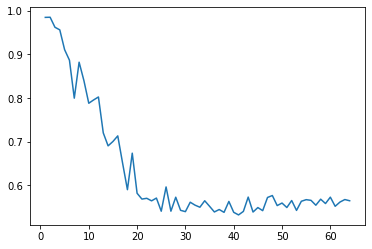

In [40]:
plt.plot(np.arange(1,65),[np.mean(x[1]) for x in resIM.values()])

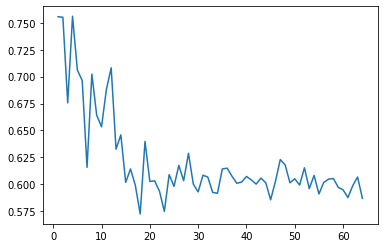

In [41]:
plt.plot(np.arange(1,65),[np.mean(x[2]) for x in resIM.values()])

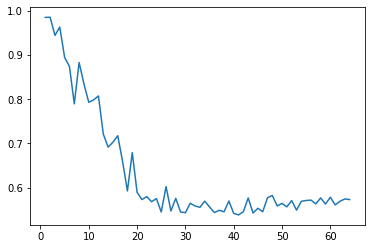

In [42]:
plt.plot(np.arange(1,65),[np.mean(np.diag(x[0])) for x in resIM.values()])